# Evaluate

In this notebook we evaluate the accuracy of the predicted alignments.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os.path
import pandas as pd
import pickle

In [3]:
ANNOTATIONS_ROOT = Path('Chopin_Mazurkas/annotations_beat')
query_list = Path('cfg_files/query.test.list')

### Evaluate hypothesis directory

First evaluate a single hypothesis directory.

In [4]:
def eval_dir(hypdir, querylist, hop_sec, savefile = None):
    
    allErrs = {}
    cnt = 0
    print(f'Processing {hypdir} ', end='')
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir + '/' + basename + '.pkl'
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
            allErrs[basename] = eval_file(hypfile, hop_sec)
            cnt += 1
            if cnt % 500 == 0:
                print(".", end='')
    print(' done')
    if savefile:
        pickle.dump(allErrs, open(savefile, 'wb'))
        
    return allErrs

In [5]:
def eval_file(hypfile, hop_sec):
    parts = os.path.basename(hypfile).split('__')
    assert len(parts) == 2
    piece = extractPieceName(parts[0])
    annotfile1 = (ANNOTATIONS_ROOT / piece / parts[0]).with_suffix('.beat')
    annotfile2 = (ANNOTATIONS_ROOT / piece / parts[1]).with_suffix('.beat')
    gt1 = getTimestamps(annotfile1)
    gt2 = getTimestamps(annotfile2)
    hypalign = loadAlignment(hypfile) # warping path in frames
    if hypalign is None:
        err = [] # no valid path
    else:
        pred2 = np.interp(gt1, hypalign[0,:]*hop_sec, hypalign[1,:]*hop_sec)
        err = pred2 - gt2
    return err

In [6]:
def extractPieceName(fullpath):
    basename = os.path.basename(fullpath) # e.g. Chopin_Op068No3_Sztompka-1959_pid9170b-21
    parts = basename.split('_')
    piece = '_'.join(parts[0:2]) # e.g. Chopin_Op068No3
    return piece

In [7]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])

In [8]:
def loadAlignment(hypfile):
    with open(hypfile, 'rb') as f:
        d = pickle.load(f)
    return d

In [69]:
# hypdir = 'experiments_test/pardtw_2_clean'
# savefile = 'evaluations_test/pardtw_2_clean.pkl'
# hop_sec = 512 * 1 / 22050
# allErrs = eval_dir(hypdir, query_list, hop_sec, savefile)

Processing experiments_test/pardtw_2_clean ............... done


Now evaluate all hypothesis directories.

In [9]:
def eval_all_dirs(rootdir, querylist, hop_sec, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    for hypdir in glob.glob(f'{rootdir}/pardtw_*'):
        savefile = outdir + '/' + os.path.basename(hypdir) + '.pkl'
        allErrs = eval_dir(hypdir, querylist, hop_sec, savefile = savefile)

In [10]:
EXPERIMENTS_ROOT = 'experiments_test'
hop_sec = 512 * 1 / 22050
outdir = 'evaluations_test'
eval_all_dirs(EXPERIMENTS_ROOT, query_list, hop_sec, outdir)

Processing experiments_test/pardtw_32_clean ............... done
Processing experiments_test/pardtw_8_clean ............... done
Processing experiments_test/pardtw_2_clean ............... done
Processing experiments_test/pardtw_4_clean ............... done
Processing experiments_test/pardtw_16_clean ............... done


### Plot error vs tolerance

In [11]:
def calc_error_rates(errFile, maxTol):
    
    # read from file
    with open(errFile, 'rb') as f:
        allErrs = pickle.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        errs = np.array(allErrs[query])
        errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [12]:
def calc_error_rates_batch(indir, basenames, maxTol):
    errRates = np.zeros((len(basenames), maxTol+1))
    allErrVals = []
    print('Computing error rates ', end='')
    for i, basename in enumerate(basenames):
        errFile = indir + '/' + basename + '.pkl'
        errRates[i,:], errors = calc_error_rates(errFile, maxTol)
        allErrVals.append(errors)
        print('.', end='')
    print(' done')
    return errRates, allErrVals

In [13]:
def plot_multiple_roc(errRates, basenames):
    numSystems = errRates.shape[0]
    maxTol = errRates.shape[1] - 1
    for i in range(numSystems):
        plt.plot(np.arange(maxTol+1), errRates[i,:] * 100.0)
    plt.legend(basenames, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Error Tolerance (ms)')
    plt.ylabel('Error Rate (%)')
    plt.show()
    return

In [18]:
EVAL_ROOT_DIR = 'evaluations_test'
#toPlot1 = ['dtw_clean', 'dtw_awgn15dB', 'dtw_awgn5dB', 'dtw_awgn-5dB']
#toPlot2 = ['predrop_.3_clean', 'predrop_.3_awgn15dB', 'predrop_.3_awgn5dB', 'predrop_.3_awgn-5dB']
#toPlot3 = ['postdrop_.1_clean', 'postdrop_.1_awgn15dB', 'postdrop_.1_awgn5dB', 'postdrop_.1_awgn-5dB']
#toPlot = toPlot1 + toPlot2 + toPlot3
#toPlot = ['dtw_clean', 'predrop_.3_clean', 'postdrop_.3_clean']
toPlot = ['dtw_clean', 'segmental_2_clean', 'segmental_4_clean', 'segmental_8_clean', 'segmental_16_clean', 'segmental_32_clean', 'pardtw_2_clean', 'pardtw_4_clean', 'pardtw_8_clean', 'pardtw_16_clean', 'pardtw_32_clean']
#toPlot2 = ['predrop_0.1_awgn15dB', 'predrop_0.1_awgn5dB', 'predrop_0.1_awgn-5dB', 'predrop_0.3_awgn15dB', 'predrop_0.3_awgn5dB', 'predrop_0.3_awgn-5dB', 'predrop_0.5_awgn15dB', 'predrop_0.5_awgn5dB', 'predrop_0.5_awgn-5dB']
#toPlot = toPlot1 + toPlot2
#toPlot = ['dtw_awgn15dB', 'dtw_awgn5dB', 'dtw_awgn-5dB', 'predrop_.3_clean', 'predrop_.3_awgn15dB', 'predrop_.3_awgn5dB', 'predrop_.3_awgn-5dB', 'predrop_.5_awgn15dB', 'predrop_.5_awgn5dB', 'predrop_.5_awgn-5dB']
maxTol = 1000 # in msec
errRates, errVals = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot, maxTol)

Computing error rates ........... done


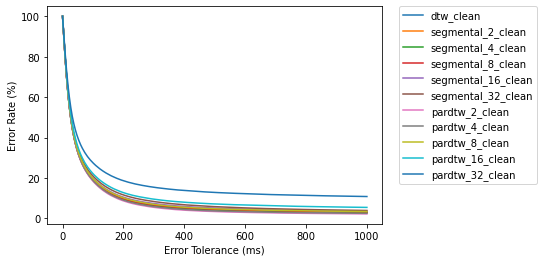

In [19]:
plot_multiple_roc(errRates, toPlot)

### Histogram of selected error rates

In [20]:
def plot_grouped_histogram1(errRates, basenames, tols):  
    # Histogram grouped by tolerance
    
    # first construct DataFrame
    data = []
    for i, system in enumerate(basenames):
        for tol in tols:
            data.append((system, tol, errRates[i,tol] * 100.0))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error'])
    
    # grouped barplot
    sns.barplot(x="Tolerance", y="Error", hue="System", data=df)
    plt.xlabel("Tolerance (ms)", size=14)
    plt.ylabel("Error Rate", size=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    return

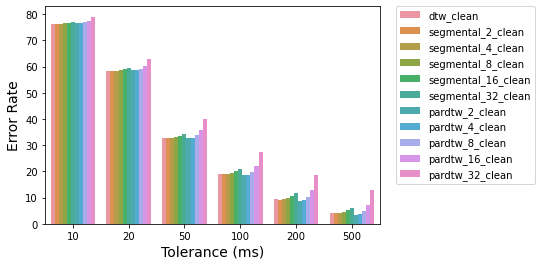

In [21]:
tols = [10, 20, 50, 100, 200, 500] # in msec
plot_grouped_histogram1(errRates, toPlot, tols)

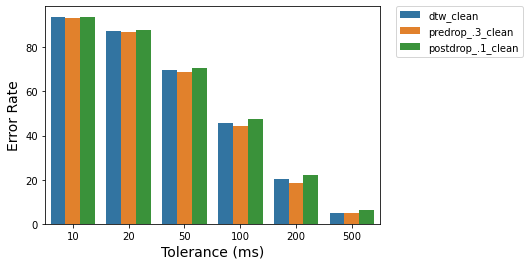

In [148]:
tols = [10, 20, 50, 100, 200, 500] # in msec
idxs = [0, 4, 8]
plot_grouped_histogram(errRates[idxs,:], [toPlot[i] for i in idxs], tols)

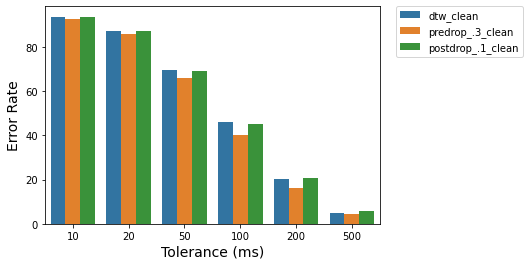

In [142]:
tols = [10, 20, 50, 100, 200, 500] # in msec
idxs = [0, 4, 8]
plot_grouped_histogram(errRates[idxs,:], [toPlot[i] for i in idxs], tols)

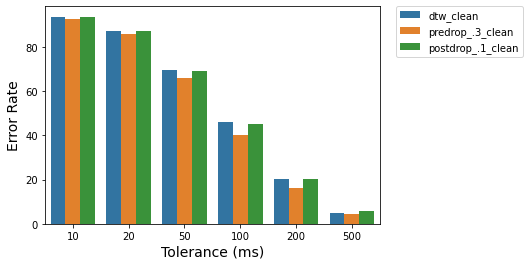

In [136]:
tols = [10, 20, 50, 100, 200, 500] # in msec
idxs = [0, 4, 8]
plot_grouped_histogram(errRates[idxs,:], [toPlot[i] for i in idxs], tols)

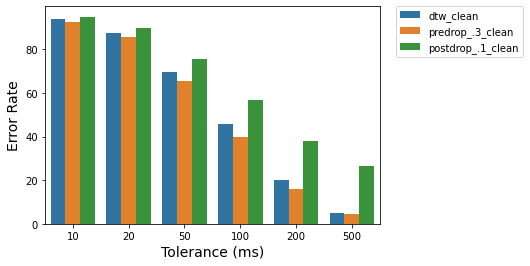

In [31]:
tols = [10, 20, 50, 100, 200, 500] # in msec
idxs = [0, 4, 8]
plot_grouped_histogram(errRates[idxs,:], [toPlot[i] for i in idxs], tols)

In [143]:
def plot_grouped_histogram2(errRates, basenames, tol):  
    # Histogram grouped by SNR
    
    # first construct DataFrame
    data = []
    for i, system in enumerate(basenames):
        parts = system.split('_')
        system = parts[0]
        noiseLevel = parts[-1]
        data.append((system, noiseLevel, errRates[i,tol] * 100.0))
    df = pd.DataFrame(data, columns = ['System', 'SNR', 'Error'])
    
    # grouped barplot
    sns.barplot(x="SNR", y="Error", hue="System", data=df)
    plt.xlabel("SNR", size=14)
    plt.ylabel("Error Rate", size=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    return

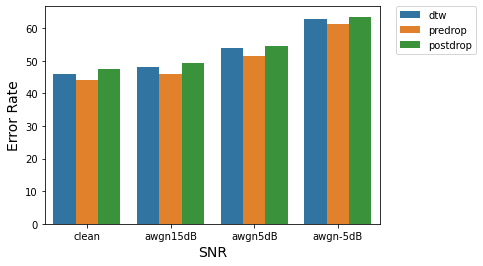

In [149]:
tol = 100 # in msec
plot_grouped_histogram2(errRates, toPlot, tol)

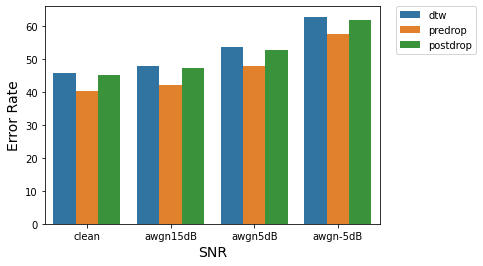

In [144]:
tol = 100 # in msec
plot_grouped_histogram2(errRates, toPlot, tol)

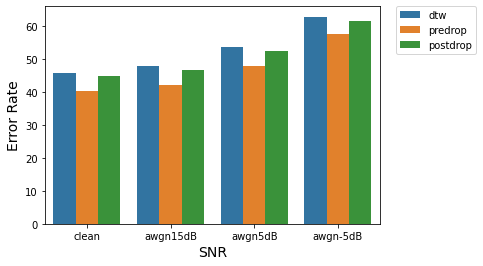

In [138]:
tol = 100 # in msec
plot_grouped_histogram2(errRates, toPlot, tol)

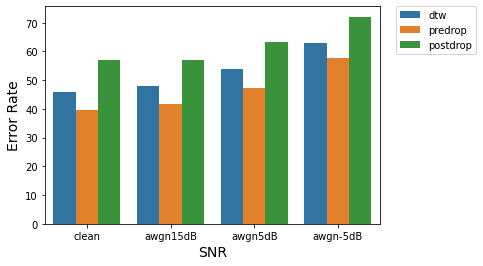

In [60]:
tol = 100 # in msec
plot_grouped_histogram2(errRates, toPlot, tol)

### Visualize Sample Trajectories

In [59]:
#exp_dir = 'experiments/dtw_clean'
#exp_dir = 'experiments/postdrop_.1_clean'
exp_dir = 'experiments_train/predrop_0.5_clean'
alignfile = f'{exp_dir}/Chopin_Op017No4_Shebanova-2002_pid9072-13__Chopin_Op017No4_Smith-1975_pid9054-13.pkl'
#alignfile = f'{exp_dir}/Chopin_Op068No3_Smith-1975_pid9054b-21__Chopin_Op068No3_Tomsic-1995_pid9190-11.pkl' 

In [60]:
def plotTrajectories(alignfile, titleStr = None):
    wps = loadAlignments(alignfile)
    print(len(wps))
    for wp in wps:
        plt.plot(wp[0,-500:], wp[1,-500:])
    if titleStr:
        plt.title(titleStr)

10


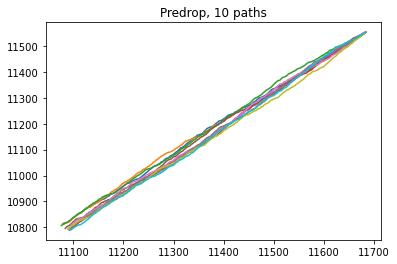

In [61]:
#plotTrajectories(alignfile, 'DTW')
plotTrajectories(alignfile, 'Predrop, 10 paths')
#plotTrajectories(alignfile, 'Postdrop, 30 paths')